# TechBot

**Author:** Florencia Marrocchi

TechBot is a technical question-answering bot specialized in GCP AI tools. It leverages a knowledge base obtained from the internal system called YAQS (Yet Another Question System) to provide accurate responses. The main objective of this project is to gather specific topic-related answers in the expected format, serving both regular users and technical personnel responsible for addressing user inquiries. Throughout the development process, various prompt tuning tests are conducted to compare the obtained results. These tests aim to refine the prompts used by TechBot and improve the quality and relevance of the answers. By continuously evaluating and optimizing the system.


#  0.Initial Config




In [ ]:
# Install dependencies
! pip uninstall -y google-cloud-aiplatform
! pip install google-cloud-aiplatform --upgrade --user
# Install gradio for UI
! pip install gradio
# Install ROUGE metric
! pip install rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [ ]:
# Restart kernel after installs so that the environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
# Authenticate
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
# Set parameters
PROJECT_ID = "cloud-llm-preview4"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
MODEL = "text-bison@001" #@param {type:"string"}

# 1.Data extraction from YAQS
Using YAQS the internal app of google, obtain examples of technical questions to add to the prompt of the model.


Query used to get the content:

*SELECT q.text as input, q.answers[0].text as output,
FROM yaqs.questions_cloud.latest AS q
WHERE ARRAY_LENGTH(q.answers)>0 AND
  (REGEXP_CONTAINS(q.text, 'vertex') OR REGEXP_CONTAINS(q.text, 'workbench') OR REGEXP_CONTAINS(q.text, 'jupyter') OR
  REGEXP_CONTAINS(q.text, 'notebook') OR REGEXP_CONTAINS(q.text, 'vertexai') OR REGEXP_CONTAINS(q.text, 'aiplatform'))
ORDER BY q.creation.time DESC
LIMIT 1000;*

The output of the query was saved on a json file names "yaqs-examples.json"



In [ ]:
# Connect colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Generate some ways to sign the answer
signs = ['Glad to assist! TechBot',
          'Thanks! TechBot',
          'I am here to help! TechBot',
          'Happy to provide support! TechBot',
          'If you need any additional assistance, feel free to ask! TechBot',
          'Cheers, TechBot']

In [ ]:
import json
import random

json_file_path = '/content/drive/MyDrive/q&a_project/yaqs-examples-1000.json'

# Open the JSON file
with open(json_file_path) as file:
    # Load the JSON data
    data = json.load(file)

# Remove the first element (line) that are the column names.
data = data[1:]

# Reduce to 50 examples (prompt tuning has length limits)
data = data[:60]

EXAMPLES = []

# Iterate over each row in the JSON data
for row in data:
  # Create line with the input and output information for each question in the json data
  if(len(row[0])<1018 and len(row[1])<1015): # Max length of input/output field. Discard the bigger ones
    new_input = "user: " + row[0]
    new_output = f"""TechBot: {row[1]}\n{random.choice(signs)}"""
    EXAMPLES.append(new_input + "\n" + new_output + "\n")

# Print info about the examples to use in the prompt
print("--- We have ", len(EXAMPLES), "examples.---")
print("---",len(data) - len(EXAMPLES), "discarded examples because of length.---")
#print(" ".join(EXAMPLES)) # Print content of all examples

# Input token limit: 8196
# Note: For the PaLM 2 model, token is equivalent to about 4 characters. 100 tokens are about 60-80 English words.
print("---", len(" ".join(EXAMPLES))/4, "< 8196 that is the token limit for the current model.", "---")


--- We have  25 examples.---
--- 35 discarded examples because of length.---
--- 6233.75 < 8196 that is the token limit for the current model. ---


# 2.Import and Initialize Text Model

In [ ]:
import vertexai
from vertexai.preview.language_models import TextGenerationModel, InputOutputTextPair

vertexai.init(project = PROJECT_ID, location = LOCATION)

# create text model
text_model = TextGenerationModel.from_pretrained(MODEL)

### 2.0. Model parameters

In [ ]:
# Temperature controls the degree of randomness in token selection.
TEMPERATURE = 0.025 # @param {type:"number"}

# Tokens are selected from most probable to least until the sum of their probabilities equals the top_p value.
TOP_P = 0.8 # @param {type:"number"}

# A top_k of 1 means the selected token is the most probable among all tokens.
TOP_K = 5 # @param {type:"number"}

# Token limit determines the maximum amount of text output.
MAX_OUTPUT_TOKENS = 1024 # @param {type:"number"}


In [ ]:
parameters = {
    "max_output_tokens": MAX_OUTPUT_TOKENS,
    "temperature": TEMPERATURE,
    "top_k": TOP_K,
    "top_p": TOP_P,
}

In [ ]:
CONTEXT = """You are a dedicated technical virtual assistant, equipped with extensive knowledge of AI and the Google Cloud Platform (GCP).
              When you know the user name, add it at the beginning of the answer. Add your name "TechBot" at the end.
              If you are not sure then ask for more information or say you do not know.
          """

In [ ]:
QUESTION = "Hi I am Florencia,  I'm currently going through the automl notebooks to test how it works for some retail clients. Everything imports correctly except for the automl table client. I keep encountering import errors. For example, I can call automl.AutoMlClient() without any issues, but when I try to call automl.TablesClient, I receive the following error message:  arduino Copy code AttributeError: module 'google.cloud.automl_v1beta1' has no attribute 'TablesClient' Do you have any idea what might be causing this? Is it a known issue?" # @param {type:"string"}

In [ ]:
def create_prompt(question, context, examples):
  PROMPT = f"""
    {context}.

    Answer the question below using the context provided:
    {examples}
    user: {question}
    TechBot:
    """
  return PROMPT

### 2.1. Zero-shot prompt

In [ ]:
PROMPT = create_prompt(QUESTION, CONTEXT, "") # No examples

In [ ]:
zero_shot_model = text_model.predict(
    prompt=PROMPT,
    **parameters
)
zero_shot_model

Hi Florencia, 

I'm sorry to hear that you're having trouble with the automl table client. I've looked into the issue and it seems like it's a known issue. The automl table client is currently in beta and there are some known issues with it. I've found a few workarounds that you can try.

One workaround is to use the automl.TablesClientBeta() class instead of the automl.TablesClient() class. This class is still in beta, but it seems to be more stable.

Another workaround is to use the automl.TablesClient() class with the `experimental` flag. This will enable some experimental features that may help to fix the issue.

I hope this helps! Let me know if you have any other questions.

## 2.2. Few-shot prompt

In [ ]:
PROMPT = create_prompt(QUESTION, CONTEXT, EXAMPLES)

In [ ]:
few_shot_model = text_model.predict(
    prompt=PROMPT,
    **parameters
)
few_shot_model

Hi Florencia,

I'm sorry to hear that you're having trouble with the automl table client. I've looked into the issue and it seems like it's a known issue. The automl table client is currently in beta and there are some known issues with it. I've added your issue to the list of known issues and I'll let you know as soon as there's a fix.

In the meantime, you can try using the automl v1 client instead. The automl v1 client is more stable and has fewer known issues.

I hope this helps!

Cheers,
TechBot

## 2.3. Fine Tuning

### 2.3.1. Prepare data
The JSONL format is required as input to fine-tune the model

#### Set path parameters

In [ ]:
# Specify the paths to the JSON and JSONL files
json_file_path = '/content/drive/MyDrive/q&a_project/yaqs-examples-1000.json'  # @param {type:"string"}
jsonl_file_path = '/content/drive/MyDrive/q&a_project/dataset-1000.jsonl'   # @param {type:"string"}
train_data_path = '/content/drive/MyDrive/q&a_project/train-data.jsonl'   # @param {type:"string"}
test_data_path = '/content/drive/MyDrive/q&a_project/test-data.jsonl'   # @param {type:"string"}

# Nombre del bucket de GCS
bucket_name = "bucket_cfm"   # @param {type:"string"}
# Nombre del archivo en el bucket
target_train_file_name = "train_data_1000.jsonl"  # @param {type:"string"}

#### Convert json to jsonl
JSONL is the erquired format to tune the model.

In [ ]:
import json
import pandas as pd
import random

def convert_json_to_jsonl(json_file_path, jsonl_file_path):
  with open(json_file_path, 'r') as json_file, open(jsonl_file_path, 'w') as jsonl_file:
      # Load JSON data
      data = json.load(json_file)

      # Remove the first element (line) that are the column names.
      data = data[1:]

      # Iterate over JSON objects
      for obj in data:
        try:
          # Remove newlines from obj[0] and obj[1]
          input_text = obj[0].replace('\n', '')
          output_text = obj[1].replace('\n', '')

          # Replace " with ´ because the jsonl doesn't recognize the character
          input_text = input_text.replace('"', '´')
          output_text = output_text.replace('"', '´')

          # Generate a random sign and add to the end of the answer
          output_text = output_text + '\n' + random.choice(signs)

          # Write each object as a separate line in the JSONL file
          json_line = json.dumps({"input_text": input_text, "output_text": output_text}) + '\n'
          jsonl_file.write(json_line)

        except json.JSONDecodeError:
          # Handle invalid JSON lines here if needed
          print("ignore line")
          pass

  print("Conversion complete.")

# Convert JSON to JSONL
convert_json_to_jsonl(json_file_path, jsonl_file_path)

Conversion complete.


### 2.3.2. Split the data
Split dataset into training and validation sets.

In [ ]:
# Define the split ratio
train_ratio = 0.8  # 80% para entrenamiento, 20% para validación

# Load the JSONL file
data = []
with open(jsonl_file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Shuffle the data
random.shuffle(data)

# Calculate the split indices
train_size = int(len(data) * train_ratio)
train_data = data[:train_size]
val_data = data[train_size:]

# Save the training and validation sets to separate files
with open(train_data_path, 'w') as train_file:
    for item in train_data:
        train_file.write(json.dumps(item) + '\n')

with open(test_data_path, 'w') as val_file:
    for item in val_data:
        val_file.write(json.dumps(item) + '\n')

print('done.')

done.


#### Upload JSONL local file to GCS

In [ ]:
from google.cloud import storage

def upload_jsonl_to_gcs(bucket_name, local_file_path, target_train_file_name):
    """Uploads a local JSONL file to a Google Cloud Storage bucket."""
    # Instantiates a client
    storage_client = storage.Client()

    # Get the bucket
    bucket = storage_client.bucket(bucket_name)

    # Upload the file to the bucket
    blob = bucket.blob(target_train_file_name)
    blob.upload_from_filename(local_file_path)

    print(f"File {local_file_path} uploaded to {bucket_name}/{target_train_file_name}")

# Llamada a la función para cargar el archivo en el bucket
upload_jsonl_to_gcs(bucket_name, train_data_path, target_train_file_name)


File /content/drive/MyDrive/q&a_project/train-data.jsonl uploaded to bucket_cfm/train_data_1000.jsonl


### 2.3.3. Create fine-tuned model

In [ ]:
# Define model to be tuned

model_display_name = 'techbot_q&a'
tuned_model = TextGenerationModel.from_pretrained("text-bison@001")

In [ ]:
# tune the model (note: this may take up to an hour)
"""Tune a new model, based on a prompt-response data.

  "training_data" can be either the GCS URI of a file formatted in JSONL format
  (for example: training_data=f'gs://{bucket}/{filename}.jsonl'), or a pandas
  DataFrame. Each training example should be JSONL record with two keys, for
  example:
    {
      "input_text": <input prompt>,
      "output_text": <associated output>
    },
  or the pandas DataFame should contain two columns:
    ['input_text', 'output_text']
  with rows for each training example.

  Args:
    tuned_model_location: GCP Region, used to initialize aiplatform
    training_data: GCS URI of training file or pandas dataframe of training data
    train_steps: Number of training steps to use when tuning the model.
  """
tuned_model.tune_model(
    training_data= f'gs://{bucket_name}/{target_train_file_name}',
    train_steps=100,
    tuning_job_location="europe-west4",
    tuned_model_location="us-central1",
)

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20230623180041


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20230623180041


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20230623180041')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20230623180041')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/tune-large-model-20230623180041?project=308351622118


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/tune-large-model-20230623180041?project=308351622118


PipelineJob projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20230623180041 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20230623180041 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob run completed. Resource name: projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20230623180041


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob run completed. Resource name: projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20230623180041


Tuning has completed. Created Vertex Model: projects/308351622118/locations/us-central1/models/4840694499283828736


INFO:vertexai.language_models._language_models:Tuning has completed. Created Vertex Model: projects/308351622118/locations/us-central1/models/4840694499283828736


In [ ]:
# get deployed model to use
tuned_model_name = "projects/308351622118/locations/us-central1/models/4840694499283828736"
tuned_model = TextGenerationModel.from_pretrained(MODEL).get_tuned_model(tuned_model_name)
tuned_model

In [ ]:
# generate prompt to run the tuned model
PROMPT = create_prompt(QUESTION, CONTEXT, "") # No examples because they are in the tuned model

In [ ]:
# run the model
tuned_model.predict(
    prompt= PROMPT,
    max_output_tokens = MAX_OUTPUT_TOKENS,
    temperature = TEMPERATURE,
    top_p = TOP_P,
    top_k = TOP_K,
)

Hi Florencia, 

    I'm sorry to hear that you are having trouble with the automl table client. I have not encountered this issue before, but I will do some research and see if I can find a solution. In the meantime, you can try the following:

    1. Make sure that you are using the latest version of the automl library.
    2. Try reinstalling the automl library.
    3. Try creating a new notebook and importing the automl library.

    If none of these solutions work, please let me know and I will continue to investigate.

    Hope this helps!

    TechBot

# 3.Evaluation
We will run all the questions in the test set and then compare the answer given by the Agent with the answer we have in the dataset.

## 3.1.Human Evaluation

Convert JSONL to DataFrame

In [ ]:
import pandas as pd
import json

# Read the JSONL file and parse each line
data = []

# We want to get 10 responses
num_responses = 25

with open(jsonl_file_path, 'r') as file:
    i = 0
    for line in file:
      if i < num_responses:
        json_object = json.loads(line)
        user_question = json_object['input_text']
        given_answer = json_object['output_text']


        try:
          # Add answer given by the basci model
          basic_model = text_model.predict(
                                  prompt = f"user: {user_question} \nTechBot:",
                                  **parameters
                              )

          # Add answer given by the zero-shot Agent
          zero_shot_model = text_model.predict(
                                  prompt=create_prompt(user_question, CONTEXT, ""),
                                  **parameters
                              )
          # Add answer given by the few-shot Agent
          few_shot_model = text_model.predict(
                                  prompt=create_prompt(user_question, CONTEXT, EXAMPLES),
                                  **parameters
                              )

          # Add answer given by the Tuned Agent
          tuned_agent_answer = tuned_model.predict(
                                prompt=create_prompt(user_question, CONTEXT, ""),
                                **parameters
                              )
          data.append({'user_question': user_question, 'given_answer': given_answer, 'basic_model': basic_model, 'zero_shot_answer': zero_shot_model,
                       'few_shot_answer': few_shot_model, 'tuned_agent_answer': tuned_agent_answer})
          i += 1
        except:
          print("error")
          continue

      else:
            break  # Exit the loop once the desired number of elements have been processed

# Create a DataFrame from the parsed data
df = pd.DataFrame(data, columns=['user_question', 'given_answer', 'basic_model', 'zero_shot_answer', 'few_shot_answer', 'tuned_agent_answer'])
df


error


,user_question,given_answer,basic_model,zero_shot_answer,few_shot_answer,tuned_agent_answer
0,I am reaching out to you to clarify/confirm if...,"I think generally, we advise against creating ...",Thank you for reaching out. I'm happy to help ...,"User, thank you for reaching out. I have revie...","Hi,\n\nI'm not sure I understand the question....","Hi [user],\n\n I'm not sure if I understand..."
1,IHAC that their daily/monthly active user coun...,One thing you could do is to have them turn on...,"Sure, I can help you with that. Here are a few...","Hi user, I'm sorry to hear that you are experi...","Hi,\n\nI'm sorry to hear that you're experienc...","Hi IHAC,\n\n I'm sorry to hear that you're ..."
2,"Dataflow Team, This is a question from a custo...",JdbcIO is not supported as a source connector ...,Thank you for your question. I'm afraid I can'...,"Hi user,\n\nI'm not sure if it's okay to sugge...","Hi,\n\nI'm not sure if I understand the questi...","Hi Dataflow Team,\n\n I'm not sure if it's ..."
3,Question: I got a question passed on that the ...,"Hi Lieze,The select google customers refers to...","Hi there, I'm here to help you with your quest...","Hi Cacholong,\n\nI'm sorry, but I don't have a...","Hi,\n\nI'm sorry, but I can't answer this ques...","Hi Cacho,\n\n Thanks for reaching out to Go..."
4,"Hello experts,My customer want to start using ...","Hi Mikael, The Datastream Oracle CDC solution ...","Hi Mikael, thanks for your question. I'm happy...","Hi Mikael,\n\nI'm not an Oracle expert either,...","Hi Mikael,\n\n I'm not an Oracle expert eit...","Hi Melika,\n\n I'm sorry to hear that you'r..."
5,Question:Kubernetes nodes have been restarted....,"Hey Jessica,Please forward this documentation ...",I understand that you are having an issue with...,"Hi Compliance Srl,\n\nI'm sorry to hear that y...","Hi,\n\nI'm sorry to hear that you're having tr...","Hi Compliance Srl,\n\n I'm sorry to hear th..."
6,**Question:**----------Direct question from th...,"Hi Tom,This use case seems to be a good fit fo...","Hi Fejron, thanks for reaching out. I'm happy ...","Hi Fejron, thanks for your question. I'm not s...","Hi,\n\nI hope you are well.\n\nI'm happy to he...","Hi Frenj,\n\n I'm not sure what you're aski..."
7,Due to BQ Editions I am starting to get more c...,Which info schema table are you trying to use ...,Thank you for your question. I'm afraid I can'...,"Hi user, thanks for your question. I'm not sur...","Hi,\n\nI'm sorry to hear that you're having tr...","Hi user,\n\nI'm sorry, but I don't have enough..."
8,I created a CL(cl/536444816) to add new MAF te...,Discussed with Sijun offline. Resolved the iss...,The error message is saying that the CL is try...,"Hi user, I'm sorry to hear that you're having ...","Hi,\n\nI'm sorry to hear that you're having tr...","Hi user, I'm sorry to hear that you're having ..."
9,Hello there! We're adding VPCSC to our lists o...,1. vpcsc-restricted-vip should not behave any ...,"Hi Rafael, thanks for reaching out! I'm happy ...","Hi Rafael, thanks for reaching out. I'm sorry ...","Hi Rafael,\n\n Thanks for reaching out! I'm...","Hi Rafael, thanks for reaching out. I'm sorry ..."


In [ ]:
# Escribir el DataFrame en un archivo xlsx
from datetime import datetime # para generar archivo de salida con fecha

hora_actual = datetime.now().strftime("%d-%m-%H:%M")

df.to_excel(f'/content/drive/MyDrive/q&a_project/output-{hora_actual}.xlsx', index=False)

## 3.2.Apply ROUGE metric to the model
ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics commonly used to evaluate the quality of text summarization or machine translation outputs. Here's an outline of the process:

In [ ]:
from rouge import Rouge
rouge = Rouge()

In [ ]:
df.loc[0, 'given_answer']

'I think generally, we advise against creating custom roles because there could be unknown breakages with the service. Aaron might be able to add some more color.\nHappy to provide support! TechBot'

In [ ]:
str(df.loc[0, 'few_shot_answer'])

"Hi,\n\nI'm not sure I understand the question. Can you please clarify what you're asking?\n\nThanks,\nTechBot"



*   **scores[0]**: The ROUGE scores dictionary contains a list of score dictionaries.
*   **['rouge-1']**: ROUGE-1 represents unigram overlap between the generated and reference text.
*   **['f']**: Finally, within the 'rouge-1' score dictionary, you can access the 'f' key. 'f' corresponds to the F1-score, which is a harmonic mean of precision and recall. F1-score is commonly used as a measure of performance in tasks such as text summarization or machine translation.





In [ ]:
import matplotlib.pyplot as plt
from rouge import Rouge

rouge = Rouge()
scores_basic_model = {'rouge-1': [], 'rouge-2': [], 'rouge-l': []}  # Diccionario para almacenar los puntajes ROUGE
scores_zero_model = {'rouge-1': [], 'rouge-2': [], 'rouge-l': []}  # Diccionario para almacenar los puntajes ROUGE
scores_few_model = {'rouge-1': [], 'rouge-2': [], 'rouge-l': []}  # Diccionario para almacenar los puntajes ROUGE
scores_tuned_model = {'rouge-1': [], 'rouge-2': [], 'rouge-l': []}  # Diccionario para almacenar los puntajes ROUGE


for i in range(25):
    reference_answer = df.loc[i, 'given_answer']
    generated_answer_basic = str(df.loc[i, 'basic_model'])
    generated_answer_zero = str(df.loc[i, 'zero_shot_answer'])
    generated_answer_few = str(df.loc[i, 'few_shot_answer'])
    generated_answer_tuned = str(df.loc[i, 'tuned_agent_answer'])

    # Calcular los puntajes ROUGE para cada respuesta generada por el modelo basico
    scores_basic = rouge.get_scores(generated_answer_basic, reference_answer)
    scores_basic_model['rouge-1'].append(scores_basic[0]['rouge-1']['f'])
    scores_basic_model['rouge-2'].append(scores_basic[0]['rouge-2']['f'])
    scores_basic_model['rouge-l'].append(scores_basic[0]['rouge-l']['f'])

    # Calcular los puntajes ROUGE para cada respuesta generada por zero-shot
    scores_zero = rouge.get_scores(generated_answer_zero, reference_answer)
    scores_zero_model['rouge-1'].append(scores_zero[0]['rouge-1']['f'])
    scores_zero_model['rouge-2'].append(scores_zero[0]['rouge-2']['f'])
    scores_zero_model['rouge-l'].append(scores_zero[0]['rouge-l']['f'])

    # Calcular los puntajes ROUGE para cada respuesta generada por few-shot
    scores_few = rouge.get_scores(generated_answer_few, reference_answer)
    scores_few_model['rouge-1'].append(scores_few[0]['rouge-1']['f'])
    scores_few_model['rouge-2'].append(scores_few[0]['rouge-2']['f'])
    scores_few_model['rouge-l'].append(scores_few[0]['rouge-l']['f'])

    # Calcular los puntajes ROUGE para cada respuesta generada por el modelo tuneado
    scores_tuned = rouge.get_scores(generated_answer_tuned, reference_answer)
    scores_tuned_model['rouge-1'].append(scores_tuned[0]['rouge-1']['f'])
    scores_tuned_model['rouge-2'].append(scores_tuned[0]['rouge-2']['f'])
    scores_tuned_model['rouge-l'].append(scores_tuned[0]['rouge-l']['f'])


Each ROUGE variant (ROUGE-1, ROUGE-2, and ROUGE-L) has associated recall, precision, and F1-score values. These scores indicate how well the generated summary matches the reference summary in terms of unigram overlap (ROUGE-1), bigram overlap (ROUGE-2), and the longest common subsequence (ROUGE-L). The higher the values, the better the match.

For example, in the first element, the ROUGE-1 F1-score is 0.18, indicating a moderate level of agreement between the generated and reference summaries based on unigram overlap. Similarly, the other scores provide insights into the performance of the generated summaries for different ROUGE variants.



###Grafico Rouge metric basic model

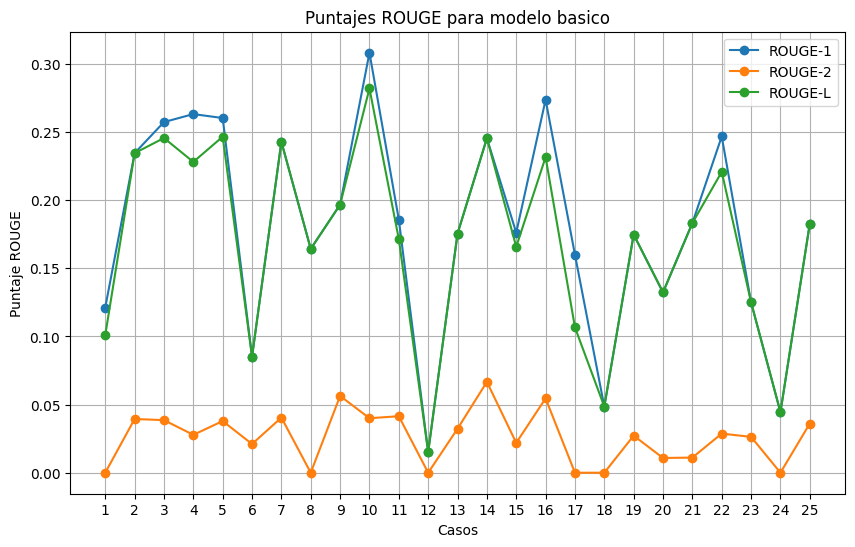

In [ ]:
# Generar el gráfico para basic model
plt.figure(figsize=(10, 6))
x = range(1, 26)  # Valores del eje X para los 25 casos

# Gráfico para ROUGE-1
plt.plot(x, scores_basic_model['rouge-1'], marker='o', label='ROUGE-1')

# Gráfico para ROUGE-2
plt.plot(x, scores_basic_model['rouge-2'], marker='o', label='ROUGE-2')

# Gráfico para ROUGE-L
plt.plot(x, scores_basic_model['rouge-l'], marker='o', label='ROUGE-L')

plt.xlabel('Casos')
plt.ylabel('Puntaje ROUGE')
plt.title('Puntajes ROUGE para modelo basico')
plt.legend()
plt.xticks(x)
plt.grid(True)
plt.show()

In [ ]:
# We can see that the 10th answer is the one with best results
# Print both answers:
print("Reference_answer: ", df.loc[9, 'given_answer'])
print("Generated_answer: ", str(df.loc[9, 'basic_model']))

Reference_answer:  1. vpcsc-restricted-vip should not behave any diffently then vpcsc-allow. VPCSC blocked all public data other then when services explicitly allow list. This allow listing is done to allow services to make default images or implementation required images available and is not intended for test images. http://go/vpcsc-enforcement-config#resource-project-allowlist1. It looks like the cloud run job you created made an LOR ´f7ed9705-f7ca-433d-af75-fea5310d8a1d´. The LOR returned a failed run and gave a 500 error code. If this run failed because of VPCSC then it should have returned 404 and had the unique error ID. It looks like something failed in your data plain around fetching a GCS image and you treat it as a 500 error instead of prorating the error. https://screenshot.googleplex.com/59hHK26bUme5jDKI Think that your internal log is looking at the wrong job. Note that the same is different. Your prod log look to be the MAF owned job that requested your job and waits on i

###Grafico metrica ROUGE zero-shot Prompt model

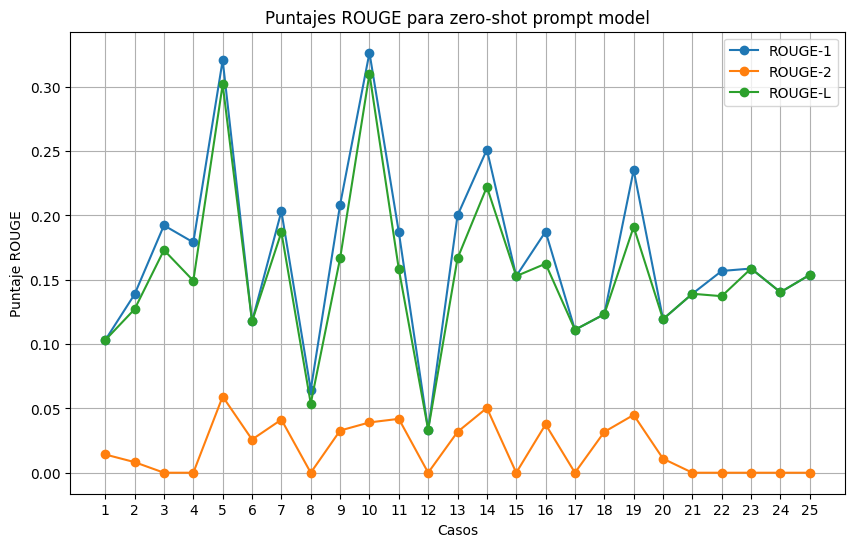

In [ ]:
# Generar el gráfico para basic model
plt.figure(figsize=(10, 6))
x = range(1, 26)  # Valores del eje X para los 25 casos

# Gráfico para ROUGE-1
plt.plot(x, scores_zero_model['rouge-1'], marker='o', label='ROUGE-1')

# Gráfico para ROUGE-2
plt.plot(x, scores_zero_model['rouge-2'], marker='o', label='ROUGE-2')

# Gráfico para ROUGE-L
plt.plot(x, scores_zero_model['rouge-l'], marker='o', label='ROUGE-L')

plt.xlabel('Casos')
plt.ylabel('Puntaje ROUGE')
plt.title('Puntajes ROUGE para zero-shot prompt model')
plt.legend()
plt.xticks(x)
plt.grid(True)
plt.show()

In [ ]:
# We can see that the 10th answer is the one with best results
# Print both answers:
print("Reference_answer: ", df.loc[9, 'given_answer'])
print("Generated_answer: ", str(df.loc[9, 'zero_shot_answer']))

Reference_answer:  1. vpcsc-restricted-vip should not behave any diffently then vpcsc-allow. VPCSC blocked all public data other then when services explicitly allow list. This allow listing is done to allow services to make default images or implementation required images available and is not intended for test images. http://go/vpcsc-enforcement-config#resource-project-allowlist1. It looks like the cloud run job you created made an LOR ´f7ed9705-f7ca-433d-af75-fea5310d8a1d´. The LOR returned a failed run and gave a 500 error code. If this run failed because of VPCSC then it should have returned 404 and had the unique error ID. It looks like something failed in your data plain around fetching a GCS image and you treat it as a 500 error instead of prorating the error. https://screenshot.googleplex.com/59hHK26bUme5jDKI Think that your internal log is looking at the wrong job. Note that the same is different. Your prod log look to be the MAF owned job that requested your job and waits on i

###Grafico metrica ROUGE few-shot Prompt model

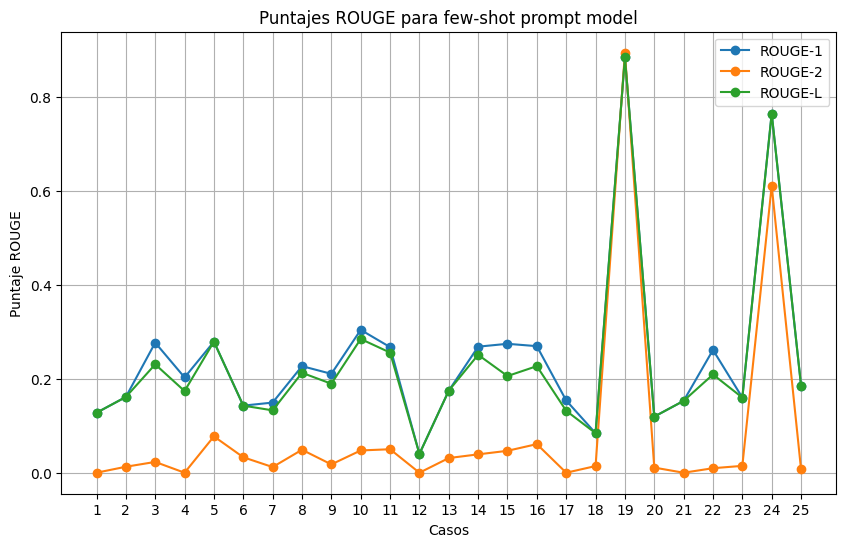

In [ ]:
# Generar el gráfico para basic model
plt.figure(figsize=(10, 6))
x = range(1, 26)  # Valores del eje X para los 25 casos

# Gráfico para ROUGE-1
plt.plot(x, scores_few_model['rouge-1'], marker='o', label='ROUGE-1')

# Gráfico para ROUGE-2
plt.plot(x, scores_few_model['rouge-2'], marker='o', label='ROUGE-2')

# Gráfico para ROUGE-L
plt.plot(x, scores_few_model['rouge-l'], marker='o', label='ROUGE-L')

plt.xlabel('Casos')
plt.ylabel('Puntaje ROUGE')
plt.title('Puntajes ROUGE para few-shot prompt model')
plt.legend()
plt.xticks(x)
plt.grid(True)
plt.show()

In [ ]:
# We can see that the 19th answer is the one with best results
# Print both answers:
print("Reference_answer: ", df.loc[18, 'given_answer'])
print("Generated_answer: ", str(df.loc[18, 'few_shot_answer']))

Reference_answer:  This feature is not available out of the box on the Google-provided Pub-Sub to Splunk Template (though there is a FR for that tracked in b/205332203). A possible workaround for the client is to fork the open-source template and create their own custom template with additional logic to reload the UDF script periodically (it's currently cached forever [here](https://github.com/GoogleCloudPlatform/DataflowTemplates/blob/3c60bec4911735960496bf66e2030dc4aa84f2ce/v1/src/main/java/com/google/cloud/teleport/templates/common/JavascriptTextTransformer.java#L140)).
I am here to help! TechBot
Generated_answer:  This feature is not available out of the box on the Google-provided Pub-Sub to Splunk Template (though there is a FR for that tracked in b/205332203). A possible workaround for the client is to fork the open-source template and create their own custom template with additional logic to reload the UDF script periodically (it's currently cached forever).\n\nCheers, TechBot\n

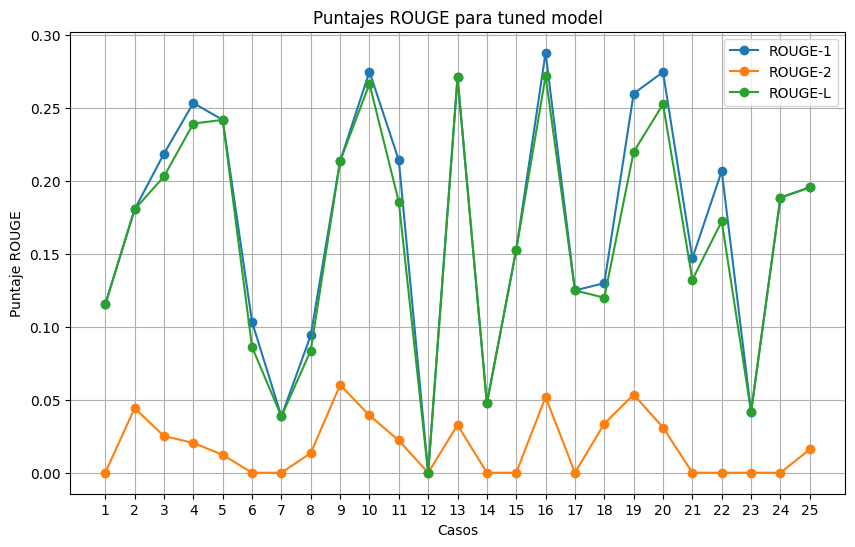

In [ ]:
# Generar el gráfico para basic model
plt.figure(figsize=(10, 6))
x = range(1, 26)  # Valores del eje X para los 25 casos

# Gráfico para ROUGE-1
plt.plot(x, scores_tuned_model['rouge-1'], marker='o', label='ROUGE-1')

# Gráfico para ROUGE-2
plt.plot(x, scores_tuned_model['rouge-2'], marker='o', label='ROUGE-2')

# Gráfico para ROUGE-L
plt.plot(x, scores_tuned_model['rouge-l'], marker='o', label='ROUGE-L')

plt.xlabel('Casos')
plt.ylabel('Puntaje ROUGE')
plt.title('Puntajes ROUGE para tuned model')
plt.legend()
plt.xticks(x)
plt.grid(True)
plt.show()

In [ ]:
# We can see that the 16th answer is the one with best results
# Print both answers:
print("Reference_answer: ", df.loc[15, 'given_answer'])
print("Generated_answer: ", str(df.loc[15, 'tuned_agent_answer']))

Reference_answer:  The event size limitation is 10mb for bigquery destination (single row).I'm sorry about the confusing notification, but the limit was specifically set to 20mb in postgres backfill so the max event in bigquery will be 10mb, due to an internal implementation detail. we will only discard rows > 10 megabytes (for bigquery destination)If the customer largest line in the table is 170 bytes and is still discarded with this error, please [open a ticket in datastream production issues](https://b.corp.google.com/issues/new?component=920272&template=1477147)
Glad to assist! TechBot
Generated_answer:  Hi user,

    The event size limit is applied to all tables in a stream. If a single table has a large row size, it can affect the other tables in the stream.

    The event size limit is 20 MB. If an event exceeds this limit, it will be discarded.

    You can increase the event size limit by setting the `max_event_size` property on the stream.

    For more information, please se

Efectively after compare results we can see that the answers are similars.

Let's see another one with a relatively good metric value.

In [ ]:
# We can see that the 10th answer is the one with best results
# Print both answers:
print("Reference_answer: ", df.loc[9, 'given_answer'])
print("Generated_answer: ", str(df.loc[9, 'tuned_agent_answer']))

Reference_answer:  1. vpcsc-restricted-vip should not behave any diffently then vpcsc-allow. VPCSC blocked all public data other then when services explicitly allow list. This allow listing is done to allow services to make default images or implementation required images available and is not intended for test images. http://go/vpcsc-enforcement-config#resource-project-allowlist1. It looks like the cloud run job you created made an LOR ´f7ed9705-f7ca-433d-af75-fea5310d8a1d´. The LOR returned a failed run and gave a 500 error code. If this run failed because of VPCSC then it should have returned 404 and had the unique error ID. It looks like something failed in your data plain around fetching a GCS image and you treat it as a 500 error instead of prorating the error. https://screenshot.googleplex.com/59hHK26bUme5jDKI Think that your internal log is looking at the wrong job. Note that the same is different. Your prod log look to be the MAF owned job that requested your job and waits on i

In [ ]:
import numpy as np

# Calcular el promedio de los puntajes ROUGE para el modelo básico
rouge_1_avg_basic = np.mean(scores_basic_model['rouge-1'])
rouge_2_avg_basic = np.mean(scores_basic_model['rouge-2'])
rouge_l_avg_basic = np.mean(scores_basic_model['rouge-l'])

# Calcular el promedio de los puntajes ROUGE para el modelo zero-shot
rouge_1_avg_zero = np.mean(scores_zero_model['rouge-1'])
rouge_2_avg_zero = np.mean(scores_zero_model['rouge-2'])
rouge_l_avg_zero = np.mean(scores_zero_model['rouge-l'])

# Calcular el promedio de los puntajes ROUGE para el modelo few-shot
rouge_1_avg_few = np.mean(scores_few_model['rouge-1'])
rouge_2_avg_few = np.mean(scores_few_model['rouge-2'])
rouge_l_avg_few = np.mean(scores_few_model['rouge-l'])

# Calcular el promedio de los puntajes ROUGE para el modelo tuneado
rouge_1_avg_tuned = np.mean(scores_tuned_model['rouge-1'])
rouge_2_avg_tuned = np.mean(scores_tuned_model['rouge-2'])
rouge_l_avg_tuned = np.mean(scores_tuned_model['rouge-l'])

print(f"Basic average: {rouge_1_avg_basic}, {rouge_2_avg_basic}, {rouge_l_avg_basic}")
print(f"Zero-shot average: {rouge_1_avg_zero}, {rouge_2_avg_zero}, {rouge_l_avg_zero}")
print(f"Few-shot average: {rouge_1_avg_few}, {rouge_2_avg_few}, {rouge_l_avg_few}")
print(f"Tuned average: {rouge_1_avg_tuned}, {rouge_2_avg_tuned}, {rouge_l_avg_tuned}")


Basic average: 0.18011485849876765, 0.02634511916094367, 0.16999586588603932
Zero-shot average: 0.16816704206982608, 0.018793581207697353, 0.1543935424332268
Few-shot average: 0.24571842524262816, 0.08247700976262008, 0.23128716369527724
Tuned average: 0.17114846203832432, 0.018242480101377877, 0.16188872142242453


# 4.Run the model with a friendly UI

In [ ]:
import gradio as gr

def TechBot(user_question):
    prompt = create_prompt(user_question, CONTEXT, EXAMPLES)

    #change between tuned_model or text_model
    model = text_model # @param {type:"string"}

    prediction = model.predict(
          prompt,
          **parameters
      )

    return prediction


## **Demo**

In [ ]:
demo = gr.Interface(fn = TechBot,
                     inputs=[gr.TextArea(label="Question")],
                     outputs = gr.TextArea(label="Answer"),
                     title = "TechBot Q&A",
                     description = "Enter a question and get the answer from a GCP expert.",
                     allow_flagging = False,
                     )


demo.launch(debug=True, share=True)

/usr/local/lib/python3.10/dist-packages/gradio/interface.py:332: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4e322813a6a78cc5b8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4e322813a6a78cc5b8.gradio.live


# **END :)**